In [1]:
from typing import List
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from recsys4daos.models import OpenPop
from recsys4daos.datasets import to_microsoft
from recsys4daos.model_selection import cvtt_open
from recsys4daos.evaluation import calculate_all_metrics

import paths

import recommenders
if recommenders.__version__ == '1.2.0':
    print("Ignoring warnings")
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_3824544/2526015065.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Ignoring warnings


In [2]:
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
ORG_NAME = 'Decentraland'
LAST_FOLD_DATE_STR: str = None # Won't use it, we will just calculate for every fold

# In this notebook this is just used for plotting and description, not "training"
# every fold is saved into the results table
LAST_FOLDS = 10

K_RECOMMENDATIONS: List[int] = [1,3,5,10,15,100]

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "Bent Finance"
SPLITS_FREQ = "2d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2023-04-30"


## Obtain dataset

In [4]:
!pwd

/home/daviddavo/recsys4daos/notebooks


In [5]:
!md5sum ../data/decentraland/*

md5sum: '../data/decentraland/*': No such file or directory


In [6]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

df = to_microsoft(dfv)

print(dfp.info())
print(dfv.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542 entries, 0 to 541
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 542 non-null    object        
 1   author             542 non-null    object        
 2   date               542 non-null    datetime64[us]
 3   start              542 non-null    datetime64[us]
 4   end                542 non-null    datetime64[us]
 5   platform_proposal  542 non-null    object        
dtypes: datetime64[us](3), object(3)
memory usage: 25.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661 entries, 0 to 660
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        661 non-null    object        
 1   proposal  661 non-null    object        
 2   voter     661 non-null    object        
 3   date      661 non-null    datetime64[us]
dtypes: dat

## Showing some info of the folds

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in cvtt_open(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['fold'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('fold')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
paths.save_folds_info(sdf_all, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
sdf = sdf_all.tail(LAST_FOLDS)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Bent Finance/baseline/folds-info_2d_normalize.parquet
fold
2023-06-29    647
2023-07-01    647
2023-07-03    648
2023-07-05    648
2023-07-07    648
2023-07-09    648
2023-07-11    654
2023-07-13    654
2023-07-15    654
2023-07-17    658
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
fold,,,,,,,,,
2023-W26,3,3,1,1.00,3.00,0,0,0.00,nan
2023-W26,1,1,1,1.00,1.00,0,0,0.00,nan
2023-W27,1,1,1,1.00,1.00,0,0,0.00,nan
2023-W27,1,0,0,0.00,nan,1,1,1.00,1.00
2023-W27,3,0,0,0.00,nan,4,2,1.33,2.00
2023-W27,4,0,0,0.00,nan,5,2,1.25,2.50
2023-W28,2,2,1,1.00,2.00,0,0,0.00,nan
2023-W28,1,1,1,1.00,1.00,0,0,0.00,nan
2023-W28,0,0,0,nan,nan,0,0,nan,nan


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
fold &  &  &  &  &  &  &  &  &  \\
2023-W26 & 3 & 3 & 1 & 1.00 & 3.00 & 0 & 0 & 0.00 & nan \\
2023-W26 & 1 & 1 & 1 & 1.00 & 1.00 & 0 & 0 & 0.00 & nan \\
2023-W27 & 1 & 1 & 1 & 1.00 & 1.00 & 0 & 0 & 0.00 & nan \\
2023-W27 & 1 & 0 & 0 & 0.00 & nan & 1 & 1 & 1.00 & 1.00 \\
2023-W27 & 3 & 0 & 0 & 0.00 & nan & 4 & 2 & 1.33 & 2.00 \\
2023-W27 & 4 & 0 & 0 & 0.00 & nan & 5 & 2 & 1.25 & 2.50 \\
2023-W28 & 2 & 2 & 1 & 1.00 & 2.00 & 0 & 0 & 0.00 & nan \\
2023-W28 & 1 & 1 & 1 & 1.00 & 1.00 & 0 & 0 & 0.00 & nan \\
2023-W28 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W29 & 6 & 4 & 1 & 0.67 & 4.00 & 2 & 1 & 0.33 & 2.00 \\
\end{tabular}



## Running openpop baseline

In [9]:
WARNING_AT_LEAST_OPEN = 5

folds = list(cvtt_open(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics = []
perfectmetrics = []

first_empty = True
ok_in_a_row = best_in_a_row = 0
max_ok_in_a_row = (-1, folds[-1].end)
for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):   
    if first_empty:
        if not train.empty:
            first_empty = False
    else:
        assert not train.empty, f"Train should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i} ({t}), all ok since {ok_in_a_row} folds ago", file=sys.stderr)
        if ok_in_a_row > max_ok_in_a_row[0]:
            max_ok_in_a_row = (ok_in_a_row, t)
        ok_in_a_row = best_in_a_row = 0
    elif len(open_proposals) < WARNING_AT_LEAST_OPEN:
        print(f"Warning, test fold {i} ({t}) with less than {WARNING_AT_LEAST_OPEN} open proposals ({len(open_proposals)}). all ok since {best_in_a_row} folds ago", file=sys.stderr)
        best_in_a_row = 0

    mdict = {'fold': t}
    pdict = {'fold': t}
    model = OpenPop(train)
    recs = model.recommend_k_items(test['userID'].unique(), max(K_RECOMMENDATIONS), recommend_from=open_proposals)
    mdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)
        # for m, f in metrics_f.items():
        #     r = f(test, recs, k=k_recs)
        #     metrics[m+f'@{k_recs}'].append(r)
    
    recs = test.copy()
    recs['prediction'] = 1
    pdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)

        # for m, f in metrics_f.items():
        #     # Need relevancy_method=None as they are unsorted
        #     r = f(test, recs, k=k_recs)
        #     perfectmetrics[m+f'@{k_recs}'].append(r)

    metrics.append(mdict)
    perfectmetrics.append(pdict)
    ok_in_a_row += 1
    best_in_a_row += 1

paths.save_dao_datum(ORG_NAME, 'max_ok_folds', str(max_ok_in_a_row[0]))
paths.save_dao_datum(ORG_NAME, 'max_ok_folds_date', str(max_ok_in_a_row[1]))
if max_ok_in_a_row == -1:
    print("All ok :>")
else:
    print("Max ok in a row:", max_ok_in_a_row)

  0%|          | 0/285 [00:00<?, ?it/s]

Warning, empty test fold 0 (2021-12-26 00:00:00), all ok since 0 folds ago
Warning, empty test fold 1 (2021-12-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 2 (2021-12-30 00:00:00), all ok since 1 folds ago
Warning, empty test fold 3 (2022-01-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 4 (2022-01-03 00:00:00), all ok since 1 folds ago
Warning, empty test fold 5 (2022-01-05 00:00:00), all ok since 1 folds ago


Warning, empty test fold 6 (2022-01-07 00:00:00), all ok since 1 folds ago
Warning, test fold 7 (2022-01-09 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 8 (2022-01-11 00:00:00), all ok since 2 folds ago
Warning, empty test fold 9 (2022-01-13 00:00:00), all ok since 1 folds ago


Warning, empty test fold 10 (2022-01-15 00:00:00), all ok since 1 folds ago
Warning, empty test fold 11 (2022-01-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 12 (2022-01-19 00:00:00), all ok since 1 folds ago
Warning, empty test fold 13 (2022-01-21 00:00:00), all ok since 1 folds ago


Warning, test fold 14 (2022-01-23 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 15 (2022-01-25 00:00:00), all ok since 2 folds ago
Warning, empty test fold 16 (2022-01-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 17 (2022-01-29 00:00:00), all ok since 1 folds ago
Warning, empty test fold 18 (2022-01-31 00:00:00), all ok since 1 folds ago


Warning, empty test fold 19 (2022-02-02 00:00:00), all ok since 1 folds ago
Warning, empty test fold 20 (2022-02-04 00:00:00), all ok since 1 folds ago


Warning, test fold 21 (2022-02-06 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 22 (2022-02-08 00:00:00), all ok since 2 folds ago
Warning, empty test fold 23 (2022-02-10 00:00:00), all ok since 1 folds ago


Warning, empty test fold 24 (2022-02-12 00:00:00), all ok since 1 folds ago
Warning, empty test fold 25 (2022-02-14 00:00:00), all ok since 1 folds ago


Warning, empty test fold 26 (2022-02-16 00:00:00), all ok since 1 folds ago
Warning, empty test fold 27 (2022-02-18 00:00:00), all ok since 1 folds ago


Warning, test fold 28 (2022-02-20 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 29 (2022-02-22 00:00:00), all ok since 2 folds ago
Warning, empty test fold 30 (2022-02-24 00:00:00), all ok since 1 folds ago


Warning, empty test fold 31 (2022-02-26 00:00:00), all ok since 1 folds ago
Warning, empty test fold 32 (2022-02-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 33 (2022-03-02 00:00:00), all ok since 1 folds ago
Warning, test fold 34 (2022-03-04 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 35 (2022-03-06 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 36 (2022-03-08 00:00:00), all ok since 3 folds ago
Warning, empty test fold 37 (2022-03-10 00:00:00), all ok since 1 folds ago


Warning, empty test fold 38 (2022-03-12 00:00:00), all ok since 1 folds ago
Warning, empty test fold 39 (2022-03-14 00:00:00), all ok since 1 folds ago


Warning, empty test fold 40 (2022-03-16 00:00:00), all ok since 1 folds ago
Warning, test fold 41 (2022-03-18 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 42 (2022-03-20 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 43 (2022-03-22 00:00:00), all ok since 3 folds ago
Warning, empty test fold 44 (2022-03-24 00:00:00), all ok since 1 folds ago


Warning, empty test fold 45 (2022-03-26 00:00:00), all ok since 1 folds ago
Warning, empty test fold 46 (2022-03-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 47 (2022-03-30 00:00:00), all ok since 1 folds ago
Warning, test fold 48 (2022-04-01 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 49 (2022-04-03 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 50 (2022-04-05 00:00:00), all ok since 3 folds ago
Warning, empty test fold 51 (2022-04-07 00:00:00), all ok since 1 folds ago


Warning, empty test fold 52 (2022-04-09 00:00:00), all ok since 1 folds ago
Warning, empty test fold 53 (2022-04-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 54 (2022-04-13 00:00:00), all ok since 1 folds ago
Warning, empty test fold 55 (2022-04-15 00:00:00), all ok since 1 folds ago


Warning, test fold 56 (2022-04-17 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 57 (2022-04-19 00:00:00), all ok since 2 folds ago
Warning, empty test fold 58 (2022-04-21 00:00:00), all ok since 1 folds ago


Warning, empty test fold 59 (2022-04-23 00:00:00), all ok since 1 folds ago
Warning, empty test fold 60 (2022-04-25 00:00:00), all ok since 1 folds ago


Warning, empty test fold 61 (2022-04-27 00:00:00), all ok since 1 folds ago
Warning, test fold 62 (2022-04-29 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 63 (2022-05-01 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 64 (2022-05-03 00:00:00), all ok since 3 folds ago
Warning, empty test fold 65 (2022-05-05 00:00:00), all ok since 1 folds ago


Warning, empty test fold 66 (2022-05-07 00:00:00), all ok since 1 folds ago
Warning, empty test fold 67 (2022-05-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 68 (2022-05-11 00:00:00), all ok since 1 folds ago
Warning, test fold 69 (2022-05-13 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 70 (2022-05-15 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 71 (2022-05-17 00:00:00), all ok since 3 folds ago
Warning, empty test fold 72 (2022-05-19 00:00:00), all ok since 1 folds ago


Warning, empty test fold 73 (2022-05-21 00:00:00), all ok since 1 folds ago
Warning, empty test fold 74 (2022-05-23 00:00:00), all ok since 1 folds ago


Warning, test fold 75 (2022-05-25 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 76 (2022-05-27 00:00:00), all ok since 2 folds ago
Warning, test fold 77 (2022-05-29 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 78 (2022-05-31 00:00:00), all ok since 2 folds ago
Warning, empty test fold 79 (2022-06-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 80 (2022-06-04 00:00:00), all ok since 1 folds ago
Warning, empty test fold 81 (2022-06-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 82 (2022-06-08 00:00:00), all ok since 1 folds ago
Warning, test fold 83 (2022-06-10 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 84 (2022-06-12 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, empty test fold 85 (2022-06-14 00:00:00), all ok since 3 folds ago


Warning, empty test fold 86 (2022-06-16 00:00:00), all ok since 1 folds ago
Warning, empty test fold 87 (2022-06-18 00:00:00), all ok since 1 folds ago


Warning, empty test fold 88 (2022-06-20 00:00:00), all ok since 1 folds ago
Warning, empty test fold 89 (2022-06-22 00:00:00), all ok since 1 folds ago


Warning, test fold 90 (2022-06-24 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, test fold 91 (2022-06-26 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 92 (2022-06-28 00:00:00), all ok since 3 folds ago
Warning, empty test fold 93 (2022-06-30 00:00:00), all ok since 1 folds ago


Warning, empty test fold 94 (2022-07-02 00:00:00), all ok since 1 folds ago
Warning, empty test fold 95 (2022-07-04 00:00:00), all ok since 1 folds ago


Warning, empty test fold 96 (2022-07-06 00:00:00), all ok since 1 folds ago
Warning, empty test fold 97 (2022-07-08 00:00:00), all ok since 1 folds ago


Warning, test fold 98 (2022-07-10 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, empty test fold 99 (2022-07-12 00:00:00), all ok since 2 folds ago


Warning, empty test fold 100 (2022-07-14 00:00:00), all ok since 1 folds ago
Warning, empty test fold 101 (2022-07-16 00:00:00), all ok since 1 folds ago


Warning, empty test fold 102 (2022-07-18 00:00:00), all ok since 1 folds ago
Warning, empty test fold 103 (2022-07-20 00:00:00), all ok since 1 folds ago


Warning, test fold 104 (2022-07-22 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, test fold 105 (2022-07-24 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 106 (2022-07-26 00:00:00), all ok since 3 folds ago
Warning, empty test fold 107 (2022-07-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 108 (2022-07-30 00:00:00), all ok since 1 folds ago
Warning, empty test fold 109 (2022-08-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 110 (2022-08-03 00:00:00), all ok since 1 folds ago
Warning, test fold 111 (2022-08-05 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 112 (2022-08-07 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 113 (2022-08-09 00:00:00), all ok since 3 folds ago
Warning, empty test fold 114 (2022-08-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 115 (2022-08-13 00:00:00), all ok since 1 folds ago
Warning, empty test fold 116 (2022-08-15 00:00:00), all ok since 1 folds ago


Warning, empty test fold 117 (2022-08-17 00:00:00), all ok since 1 folds ago
Warning, test fold 118 (2022-08-19 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 119 (2022-08-21 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 120 (2022-08-23 00:00:00), all ok since 3 folds ago
Warning, empty test fold 121 (2022-08-25 00:00:00), all ok since 1 folds ago


Warning, empty test fold 122 (2022-08-27 00:00:00), all ok since 1 folds ago
Warning, test fold 123 (2022-08-29 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 125 (2022-09-02 00:00:00) with less than 5 open proposals (3). all ok since 2 folds ago


Warning, test fold 126 (2022-09-04 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 127 (2022-09-06 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 128 (2022-09-08 00:00:00), all ok since 6 folds ago
Warning, empty test fold 129 (2022-09-10 00:00:00), all ok since 1 folds ago


Warning, empty test fold 130 (2022-09-12 00:00:00), all ok since 1 folds ago
Warning, empty test fold 131 (2022-09-14 00:00:00), all ok since 1 folds ago


Warning, empty test fold 132 (2022-09-16 00:00:00), all ok since 1 folds ago
Warning, empty test fold 133 (2022-09-18 00:00:00), all ok since 1 folds ago


Warning, test fold 134 (2022-09-20 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago
Warning, test fold 135 (2022-09-22 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 136 (2022-09-24 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 137 (2022-09-26 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 138 (2022-09-28 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago
Warning, test fold 139 (2022-09-30 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 140 (2022-10-02 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 141 (2022-10-04 00:00:00), all ok since 8 folds ago
Warning, test fold 142 (2022-10-06 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 143 (2022-10-08 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago
Warning, test fold 144 (2022-10-10 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 145 (2022-10-12 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago
Warning, test fold 146 (2022-10-14 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 147 (2022-10-16 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, empty test fold 148 (2022-10-18 00:00:00), all ok since 7 folds ago


Warning, empty test fold 149 (2022-10-20 00:00:00), all ok since 1 folds ago
Warning, empty test fold 150 (2022-10-22 00:00:00), all ok since 1 folds ago


Warning, empty test fold 151 (2022-10-24 00:00:00), all ok since 1 folds ago
Warning, test fold 152 (2022-10-26 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 153 (2022-10-28 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 154 (2022-10-30 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 155 (2022-11-01 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 156 (2022-11-03 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 157 (2022-11-05 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 158 (2022-11-07 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago
Warning, empty test fold 159 (2022-11-09 00:00:00), all ok since 8 folds ago


Warning, test fold 160 (2022-11-11 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, test fold 161 (2022-11-13 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 162 (2022-11-15 00:00:00), all ok since 3 folds ago
Warning, empty test fold 163 (2022-11-17 00:00:00), all ok since 1 folds ago


Warning, test fold 164 (2022-11-19 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, empty test fold 165 (2022-11-21 00:00:00), all ok since 2 folds ago


Warning, empty test fold 166 (2022-11-23 00:00:00), all ok since 1 folds ago
Warning, test fold 167 (2022-11-25 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 168 (2022-11-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, empty test fold 169 (2022-11-29 00:00:00), all ok since 3 folds ago


Warning, empty test fold 170 (2022-12-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 172 (2022-12-05 00:00:00), all ok since 2 folds ago
Warning, empty test fold 173 (2022-12-07 00:00:00), all ok since 1 folds ago


Warning, test fold 174 (2022-12-09 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 175 (2022-12-11 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, test fold 176 (2022-12-13 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 177 (2022-12-15 00:00:00), all ok since 4 folds ago
Warning, empty test fold 178 (2022-12-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 179 (2022-12-19 00:00:00), all ok since 1 folds ago
Warning, test fold 180 (2022-12-21 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 181 (2022-12-23 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 182 (2022-12-25 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 183 (2022-12-27 00:00:00), all ok since 4 folds ago
Warning, empty test fold 184 (2022-12-29 00:00:00), all ok since 1 folds ago


Warning, empty test fold 185 (2022-12-31 00:00:00), all ok since 1 folds ago
Warning, empty test fold 186 (2023-01-02 00:00:00), all ok since 1 folds ago


Warning, test fold 187 (2023-01-04 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 189 (2023-01-08 00:00:00) with less than 5 open proposals (3). all ok since 2 folds ago


Warning, test fold 190 (2023-01-10 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 193 (2023-01-16 00:00:00), all ok since 7 folds ago
Warning, empty test fold 194 (2023-01-18 00:00:00), all ok since 1 folds ago


Warning, test fold 195 (2023-01-20 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 196 (2023-01-22 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 197 (2023-01-24 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 198 (2023-01-26 00:00:00), all ok since 4 folds ago


Warning, empty test fold 200 (2023-01-30 00:00:00), all ok since 2 folds ago
Warning, empty test fold 201 (2023-02-01 00:00:00), all ok since 1 folds ago


Warning, test fold 202 (2023-02-03 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 203 (2023-02-05 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 204 (2023-02-07 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 205 (2023-02-09 00:00:00), all ok since 4 folds ago
Warning, test fold 206 (2023-02-11 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 207 (2023-02-13 00:00:00), all ok since 2 folds ago
Warning, test fold 208 (2023-02-15 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 209 (2023-02-17 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 211 (2023-02-21 00:00:00), all ok since 4 folds ago


Warning, test fold 213 (2023-02-25 00:00:00) with less than 5 open proposals (1). all ok since 2 folds ago
Warning, test fold 214 (2023-02-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 217 (2023-03-05 00:00:00) with less than 5 open proposals (1). all ok since 3 folds ago


Warning, test fold 218 (2023-03-07 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 220 (2023-03-11 00:00:00), all ok since 9 folds ago
Warning, empty test fold 221 (2023-03-13 00:00:00), all ok since 1 folds ago


Warning, empty test fold 222 (2023-03-15 00:00:00), all ok since 1 folds ago
Warning, test fold 223 (2023-03-17 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 224 (2023-03-19 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 225 (2023-03-21 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, empty test fold 226 (2023-03-23 00:00:00), all ok since 4 folds ago


Warning, test fold 227 (2023-03-25 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago
Warning, empty test fold 228 (2023-03-27 00:00:00), all ok since 2 folds ago


Warning, empty test fold 229 (2023-03-29 00:00:00), all ok since 1 folds ago
Warning, test fold 230 (2023-03-31 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 233 (2023-04-06 00:00:00), all ok since 4 folds ago
Warning, empty test fold 234 (2023-04-08 00:00:00), all ok since 1 folds ago


Warning, empty test fold 235 (2023-04-10 00:00:00), all ok since 1 folds ago
Warning, test fold 236 (2023-04-12 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 237 (2023-04-14 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 238 (2023-04-16 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 239 (2023-04-18 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago
Warning, empty test fold 240 (2023-04-20 00:00:00), all ok since 5 folds ago


Warning, test fold 241 (2023-04-22 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 243 (2023-04-26 00:00:00), all ok since 3 folds ago
Warning, test fold 244 (2023-04-28 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 246 (2023-05-02 00:00:00), all ok since 3 folds ago
Warning, test fold 247 (2023-05-04 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 248 (2023-05-06 00:00:00), all ok since 2 folds ago
Warning, empty test fold 249 (2023-05-08 00:00:00), all ok since 1 folds ago


Warning, test fold 250 (2023-05-10 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, test fold 251 (2023-05-12 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 252 (2023-05-14 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 253 (2023-05-16 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 256 (2023-05-22 00:00:00), all ok since 7 folds ago
Warning, empty test fold 257 (2023-05-24 00:00:00), all ok since 1 folds ago


Warning, empty test fold 260 (2023-05-30 00:00:00), all ok since 3 folds ago


Warning, empty test fold 262 (2023-06-03 00:00:00), all ok since 2 folds ago
Warning, empty test fold 263 (2023-06-05 00:00:00), all ok since 1 folds ago


Warning, empty test fold 264 (2023-06-07 00:00:00), all ok since 1 folds ago
Warning, test fold 265 (2023-06-09 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 266 (2023-06-11 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 269 (2023-06-17 00:00:00) with less than 5 open proposals (2). all ok since 3 folds ago
Warning, test fold 270 (2023-06-19 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 275 (2023-06-29 00:00:00), all ok since 11 folds ago
Warning, empty test fold 276 (2023-07-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 277 (2023-07-03 00:00:00), all ok since 1 folds ago
Warning, test fold 278 (2023-07-05 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 279 (2023-07-07 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 280 (2023-07-09 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 281 (2023-07-11 00:00:00), all ok since 4 folds ago
Warning, empty test fold 282 (2023-07-13 00:00:00), all ok since 1 folds ago


Warning, empty test fold 283 (2023-07-15 00:00:00), all ok since 1 folds ago


Max ok in a row: (11, Timestamp('2023-06-29 00:00:00'))


### Caching these results

In [10]:
odf = pd.DataFrame(metrics).set_index("fold")
paths.save_openpop(odf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
odf.describe()

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Bent Finance/baseline/openpop_2d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,...,285.000000,285.000000,285.000000,285.000000,281.000000,279.000000,279.000000,279.000000,279.000000,285.000000
mean,0.148830,0.058382,0.038538,0.019971,0.013314,0.001997,0.145906,0.149809,0.152148,0.151266,...,0.160732,0.160732,0.160732,0.137093,0.142360,0.144033,0.144684,0.144684,0.144684,0.080139
std,0.353275,0.135983,0.096725,0.056181,0.037454,0.005618,0.347952,0.343398,0.343627,0.341831,...,0.358866,0.358866,0.358866,0.334876,0.339451,0.340876,0.341645,0.341645,0.341645,0.022513
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067565
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069039
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070293
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.081034
max,1.000000,1.000000,1.000000,0.700000,0.466667,0.070000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.290544


In [11]:
pdf = pd.DataFrame(perfectmetrics).set_index("fold")
cols = [ c for c in pdf.columns if not c.startswith('time_') ]
paths.save_perfect(pdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
display(pdf.describe())
msk = (0 <= pdf[cols].min()) & (pdf[cols].max() <= 1)
if not all(msk):
    display(pdf.describe()[msk[~msk].index])
assert all( msk ), "There are metrics with wrong range"

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Bent Finance/baseline/perfect_2d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,...,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000
mean,0.452632,0.198830,0.128655,0.068538,0.045926,0.006889,0.452632,0.452632,0.452632,0.452632,...,0.452313,0.452632,0.452632,0.391586,0.439963,0.447794,0.452313,0.452632,0.452632,0.096050
std,0.498627,0.256066,0.185005,0.116442,0.079582,0.011937,0.498627,0.498627,0.498627,0.498627,...,0.498304,0.498627,0.498627,0.461384,0.490355,0.495283,0.498304,0.498627,0.498627,0.025544
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071065
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072671
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.074302
75%,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.123256
max,1.000000,1.000000,1.000000,1.000000,0.733333,0.110000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.132283


## Plotting some graphs

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,285,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,...,285.000000,285.000000,281.000000,279.000000,279.000000,279.000000,279.000000,285.000000,0.0,0.0
mean,2022-10-06 00:00:00,0.148830,0.058382,0.038538,0.019971,0.013314,0.001997,0.145906,0.149809,0.152148,...,0.160732,0.137093,0.142360,0.144033,0.144684,0.144684,0.144684,0.080139,NaN,NaN
min,2021-12-26 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067565,NaN,NaN
25%,2022-05-17 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069039,NaN,NaN
50%,2022-10-06 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070293,NaN,NaN
75%,2023-02-25 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.081034,NaN,NaN
max,2023-07-17 00:00:00,1.000000,1.000000,1.000000,0.700000,0.466667,0.070000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.290544,NaN,NaN
std,NaN,0.353275,0.135983,0.096725,0.056181,0.037454,0.005618,0.347952,0.343398,0.343627,...,0.358866,0.334876,0.339451,0.340876,0.341645,0.341645,0.341645,0.022513,NaN,NaN


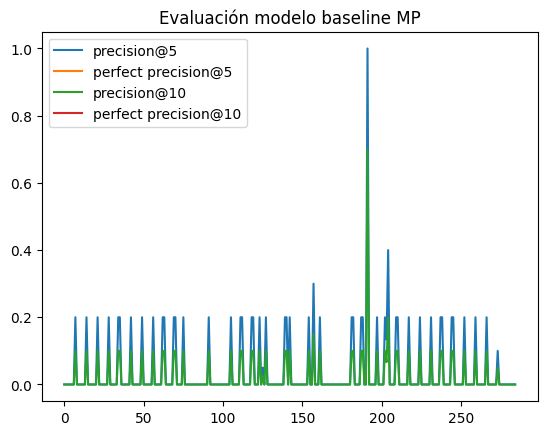

In [12]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = pdf['precision@5']
mdf['perfect precision@10'] = pdf['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

In [13]:
mdf[-LAST_FOLDS:].describe()

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,10,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.000000,0.0,0.0
mean,2023-07-08 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069860,NaN,NaN
min,2023-06-29 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068030,NaN,NaN
25%,2023-07-03 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069249,NaN,NaN
50%,2023-07-08 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069571,NaN,NaN
75%,2023-07-12 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070607,NaN,NaN
max,2023-07-17 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071876,NaN,NaN
std,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001172,NaN,NaN
